# Berman Standard State Code Generator 
This notebook generates a coder database for the mineral database used by DEW. Most of the minerals are from Berman, and can already be found in Thermoengine. Here they are given the DEW names, and altered according to Sverjensky et al. (1991). Additionally, some minerals from Helgeson are also included, necessitating an additional term in the expression for heat capacity.

Required system packages and initialization

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
import dill
sym.init_printing()

Required ENKI packages

In [2]:
from thermoengine import coder
%run core.ipynb

# Types of terms in a standard state properties description
There are three classes of terms:
1. Terms that apply over the whole of $T$-, $P$-space, $T_r \le T$, $P_r \le P$
2. Terms that apply over a specified range of $T$-, $P$-space, $(T_{r_\lambda},P_{r_\lambda}) \le (T,P) \le (T_\lambda,P_\lambda)$
3. Terms that apply to a specific $T_t$ and $P_t$ and higher $T$, $P$, $T_t \le T$, $P_t \le P$

Second-order phase transitions ($lambda$-transitions) are an example of the second type, as are order disorder transformations. First-order phase transitions are an example of the third type.  

## Create a model class for the Gibbs free energy

In [3]:
model = coder.StdStateModel()

Retrieve sympy symbols for model variables and reference conditions

In [4]:
T = model.get_symbol_for_t()
P = model.get_symbol_for_p()
Tr = model.get_symbol_for_tr()
Pr = model.get_symbol_for_pr()

### Define model expressions applicable over all of T,P space
An expression for the Gibbs free energy, $G(T,P)$ or the Helmholtz energy $A(T,V)$ is constructed.  The expression may have multiple parts.  Often the heat capacity function is postulated, then integrated to yield expressions for the entahlpy, entropy, and in combination the energy potential. Then, an equation of state (EOS) is adopted and that term is integrated in pressure or volume and added to the heat capacity integrals. This proceedure is follwed here.
#### (1) $C_P$ integrals
The isobaric heat capacity terms parameterized as: $C_P = k_0 + k_1 / T^{1/2} + k_2 / T^2 + k_3 / T^3 +k_5 T$,
and in addition the reference condition third law entropy, $ S_{Tr,Pr} $, and enthalpy of formation from the
elements, $ \Delta H_{Tr,Pr} $, constitute additional parameters:

In [5]:
k0,k1,k2,k3,k5,k6 = sym.symbols('k0 k1 k2 k3 k5 k6')
CpPr = k0+k1/sym.sqrt(T)+k2/T**2+k3/T**3+k5*T + k6/T
STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')

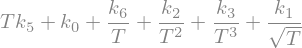

In [6]:
CpPr

Specify paramters ...

In [7]:
params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr), ('k0','J/K-m',k0), ('k1','J-K^(1/2)-m',k1),
          ('k2','J-K/m',k2),  ('k3','J-K^2',k3), ('k5','J-K^2',k5), ('k6','J-K',k6)]

Define the heat capacity contribution to the Gibbs free energy ...

In [8]:
GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))

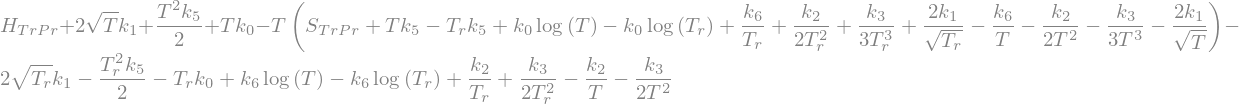

In [9]:
GPr

... and add this expression to the model

In [10]:
model.add_expression_to_model(GPr, params)

#### (2) $V$ (EOS) integrals
Next, define a volume-explicit equation of state applicable over the whole of temperature and pressure space

In [11]:
VTrPr,v1,v2,v3,v4 = sym.symbols('V_TrPr v1 v2 v3 v4')
params = [('V_TrPr', 'J/bar-m', VTrPr), ('v1','1/bar',v1), ('v2','1/bar^2',v2), ('v3','1/K',v3),  ('v4','1/K^2',v4)]

In [12]:
GPrToP = sym.integrate(VTrPr*(1+v1*(P-Pr)+v2*(P-Pr)**2+v3*(T-Tr)+v4*(T-Tr)**2),(P,Pr,P))
model.add_expression_to_model(GPrToP, params)

### Define additional lambda heat capacity terms applicable over a restricted range of T,P space
These contributions to the potential function apply over a limited range of $T,P$ or $T,V$ space.  However, the affects of these functions propagate beyond the upper limits of the range.  Say, $f(T,P)$ is the contribution to the Gibbs free energy that describes a $\lambda$-like transition over the range $({T_{\lambda ,ref}},{P_{\lambda ,ref}})$ to $({T_\lambda },{P_\lambda })$.  Then, *above the upper limit* of temperature there is a fixed entropy contribution:  
  
$- {\left. {\frac{{\partial f\left( {T,P} \right)}}{{\partial T}}} \right|_{{T_\lambda },{P_\lambda }}} = {f_S}({T_\lambda },{P_\lambda })$  
  
and *above the upper limit of pressure* there is a fixed volume contribution:  
  
${\left. {\frac{{\partial f\left( {T,P} \right)}}{{\partial P}}} \right|_{{T_\lambda },{P_\lambda }}} = {f_V}({T_\lambda },{P_\lambda })$  

the consequence of which is that for $T > T_{\lambda}$ and $P > P_{\lambda}$, there is a contribution to the Gibbs free energy of the form:  

$- \left( {T - {T_\lambda }} \right){f_S}({T_\lambda },{P_\lambda }) + \left( {P - {P_\lambda }} \right){f_V}({T_\lambda },{P_\lambda })$  

This contribution is linear in $T$ and $P$.  

The additional energetic contributions applicable above the upper range limit will be added automatically to the model function, and need not be explicitly accounted for in building the model expressions.  

#### (1) $\lambda$-transition-like heat capacity integrals 
Parameters of the Berman (1988) lambda transition model:
- $l_1$ and $l_2$, coefficients in Berman (1988)'s $lambda$-heat capacity model
- $k_{\lambda}$, $\frac{{d{T_\lambda }}}{{dP}}$ in Berman (1988)'s $lambda$-transition model
- $T_{\lambda,{P_r}}$, Temperature of the $\lambda$-transition at reference pressure
- $T_{\lambda,{ref}}$, Temperature of the lower bound of the heat capacity integral for the $\lambda$-transition at reference pressure

In [13]:
l1,l2 = sym.symbols('l1 l2')
kl = sym.symbols('k_lambda')
TlPr, Tlref = sym.symbols('T_lambda_Pr T_lambda_ref')
params = [('l1','(J/m)^(1/2)-K', l1), ('l2', '(J/m)^(1/2)/K^2', l2), ('k_lambda', 'K/bar', kl), 
          ('T_lambda_Pr', 'K', TlPr), ('T_lambda_ref', 'K', Tlref)]

Calculate the transition temperature, $T_{\lambda}$, at the pressure, $P$

In [14]:
Tl = TlPr + kl*(P-Pr)

Temperature difference between $T_{\lambda}$ at $P$ and $P_r$

In [15]:
td = TlPr - Tl

Reference temperature for lower limit of heat capacity integral.

In [16]:
tr = Tlref - td

Heat capacity due to the $\lambda$-transition at $T$ and $P$. Valid: $T_r \le T \le T_{\lambda}$.  

**Note:** The syntax of the arguments to the SymPy Piecewise expression is of the form:
```
(e1,c1), (e2,d2), ..., (eDefault, True)
```
where the sequence is evaluated left to right. *eN* is the value of the resulting expression if the condition *cN* is *True*.  *cN* is always a logical comparison.  The first *cN* that is *True* provides the value of the expression.  If no *cN* evaluate to *True*, then the resulting expression becomes *eDefault* given by the last tuple in the sequence.  See the example below.

In [17]:
Cpl = (T+td)*(l1+l2*(T+td))**2

Compute the Gibbs free energy of the lambda transition

In [18]:
Gl = sym.integrate(Cpl,(T,tr,T)) - T*sym.integrate(Cpl/T,(T,tr,T))

... and add this expression to the model

In [19]:
model.add_expression_to_model(Gl, params, exp_type='restricted', lower_limits=(tr,Pr), upper_limits=(Tl,None))

#### (2) First order phase transition terms
Berman terms valid at T $\ge$ $T_t$. Parameters (in this case $T_t$ is equivalent to $T_{\lambda}$:
- ${{\Delta}_t}H$, First order enthalpy contribution at $T_{\lambda}$

In [20]:
deltaHt = sym.symbols('H_t')
params = [('H_t','J/m', deltaHt)]

${{\Delta}_t}S = {{\Delta}_t}H/T_{\lambda}$, First order enropy contribution at $T_{\lambda}$: ${{\Delta}_t}H - T {{\Delta}_t}S = -(T-T_{\lambda}) {{\Delta}_t}H/T_{\lambda}$ 

In [21]:
GaboveTl = -(T-Tl)*deltaHt/Tl

... and add this expression to the model

In [22]:
model.add_expression_to_model(GaboveTl , params, exp_type='restricted', lower_limits=(Tl,None), upper_limits=(Tl,None))

#### (3) Order-disorder contributions
Parameters of the Berman (1988) order-disorder model:
- $d_0$, $d_1$, $d_2$, $d_3$, $d_4$, $d_5$, order-disorder coefficients from the Berman (1988) model
- $T_{D_{ref}}$, $T_D$, minimum, maximum temperature of ordering interval, $T_{D_{ref}} \le T \le T_D$

In [23]:
d0,d1,d2,d3,d4,d5 = sym.symbols('d0 d1 d2 d3 d4 d5')
TD,TDref = sym.symbols('T_D T_D_ref')
params = [('d0','J/K-m', d0), ('d1','J/K^(1/2)-m',d1), ('d2','J-K/m',d2), ('d3','J/K^2-m',d3), 
          ('d4','J/K^3-m',d4), ('d5','bar',d5), ('T_D','K',TD), ('T_D_ref','K',TDref)]

In [24]:
CpDs = d0 + d1/sym.sqrt(T) + d2/T**2 + d3*T + d4*T**2
HDs = sym.integrate(CpDs,(T,TDref,T))
SDs = sym.integrate(CpDs/T,(T,TDref,T))
VDs = HDs/d5
GDs = HDs - T*SDs + VDs*(P-Pr)

In [25]:
model.add_expression_to_model(GDs , params, exp_type='restricted', lower_limits=(TDref,None), upper_limits=(TD,None))

## Code Print the Model, compile the code and link a Python module
Name the model class

Note that the call to
```
model.create_code_module(phase=phase_name, formula=formula, params=param_dict)
```
generates fast code with unmodifiable model parameters and "calibration-" related functions.  The call to:
```
model.create_code_module(phase=phase_name, formula=formula, params=param_dict, module_type='calib')
```
generates code suitable for model parameter calibration.  
model_type is "fast" or "calib"

In [26]:
d = pd.read_csv('../dew_berman.csv')
d.head()

,name,Unnamed: 1,formula,reference,ref_state,G_ref,H_ref,S_ref,v0,k0,...,l2,dHt,d0,d1,d2,d3,d4,d5,Tdref,Td
0,HYDROXYAPATITE,14.0,Ca(5)P(3)O(13)H(1),Zhu and Sverjensky,1675.515,-6297702.0,-6694688.70,398.7352,15.822,758.81024,...,0.00000,0,0.0,0.0,0,0.0,0.0,0,0,0
1,FLUORAPATITE,12.0,Ca(5)P(3)O(12)F(1),Zhu and Sverjensky,1608.995,-6443050.0,-6823447.11,387.8568,15.753,668.77056,...,0.00000,0,0.0,0.0,0,0.0,0.0,0,0,0
2,CHLORAPATITE,12.0,Ca(5)P(3)O(12)Cl(1),Zhu and Sverjensky,1619.140,-6217424.0,-6597260.07,399.0699,16.403,663.87528,...,0.00000,0,0.0,0.0,0,0.0,0.0,0,0,0
3,DIAMOND,7.0,C(1),Birch 1966 and Fujihisa (from Fried & Howard 2...,5.740,2900.0,1895.00,2.3800,0.342,36.00400,...,0.00000,0,0.0,0.0,0,0.0,0.0,0,0,0
4,MAGNETITE,9.0,Fe(3)O(4),Berman,492.140,-1014235.0,-1117402.53,146.1142,4.452,207.93083,...,0.00061,1565,0.0,0.0,0,0.0,0.0,0,0,0


In [27]:
params = {}
for i, row in d.iterrows():
    
    species_name = row['name']
    
    if species_name[-1] == '-':
        species_name = species_name[:-1]+'_n'
    if species_name[-2] == '-':
        species_name = species_name[:-2]+'_n'+species_name[-1]
    species_name = species_name.replace('-','_')
    species_name = species_name.replace('+','_p')
    species_name = species_name.replace('(','_l_')
    species_name = species_name.replace(')','_r_')
        
    species_name = species_name.replace(',','_')
    
    params[row['name']] = {'Phase': species_name,
                          'Formula': row.formula,
                          'H_TrPr':row.H_ref + row.ref_state*298.15,
                          'S_TrPr': row.S_ref,
                          'k0': row.k0,
                          'k1': row.k1,
                          'k2': row.k2,
                          'k3': row.k3,
                          'k5': row.k5,
                          'k6': row.k6,
                          'V_TrPr': row.v0,
                          'v1': row.v3*1e-5,
                          'v2': row.v4*1e-8,
                          'v3': row.v1*1e-5,
                          'v4': row.v2*1e-5,
                          'l1': row.l1,
                          'l2': row.l2,
                          'k_lambda': row.kl,
                          'T_lambda_Pr': row.Tl,
                          'T_lambda_ref': row.Tlref,
                          'H_t': row.dHt,
                          'd0': row.d0,
                          'd1': row.d1,
                          'd2': row.d2,
                          'd3': row.d3,
                          'd4': row.d4,
                          'd5': row.d5,
                          'T_D': row.Td,
                          'T_D_ref': row.Tdref,
                          'T_r': 298.15,
                          'P_r': 1.0}

In [28]:
mod_name = 'dewminerals'
modelDB, codermod = make_custom_database(mod_name, params, working_dir='working')

/Users/simonmatthews/repos/pyQ3/notebooks/working
Creating (once only) generic fast model code file string
Creating (once only) generic model fast code template include file string
Creating (once only) generic model fast code template code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file t

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory


Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  dewminerals
Creating incl

rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
rm: tmpfile2.pyx: No such file or directory
/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/simonmatthews/repos/pyQ3/notebooks/working/dewminerals.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /Users/simonmatthews/.pyxbld/temp.macosx-10.9-x86_64-3.7/pyrex/dewminerals.c:698:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/

/Users/simonmatthews/repos/pyQ3/notebooks


In [29]:
modelDB.phase_info

,abbrev,phase_name,formula,phase_type,endmember_num


In [30]:
output = {}
for phsnm in params:
    iphs = modelDB.get_phase(phsnm)
    output[phsnm] = iphs
with open('dewminerals.pkl','wb') as file:
    dill.dump(output, file)
    file.close()

In [31]:
output['DIAMOND'].gibbs_energy(1000.0, 1000.0)